In [1]:
from imblearn.over_sampling import SMOTE, ADASYN
import numpy as np
from sklearn.metrics import confusion_matrix
from sklearn.metrics import f1_score
from sklearn import metrics
import time
from datetime import datetime, timedelta
from sklearn import svm
import pandas as pd
import matplotlib.pyplot as plt
import math
from sklearn import preprocessing
from math import sqrt
import seaborn as sns; sns.set()
import ast


def smote(x,y):
    X_resampled, y_resampled = SMOTE().fit_sample(x, y)
    #print('check',sum(y_resampled)/len(y_resampled))
    return X_resampled,y_resampled


In [2]:
tickers = ['AAPL','AMZN','GOOGL','MSFT','FB','INTC','CSCO','CMCSA','NVDA','NFLX'] 
TREND_WINDOWs = [1, 4, 7, 14, 21, 28, 49]
newsPath = '/home/simone/Desktop/NLFF/intrinioDatasetUpdated/SentimentFullAggregatedHourly/'
pricePath = '/home/simone/Desktop/NLFF/indexes/indexes'

trainPerc = 0.8

 TREND_WINDOW  AAPL  AMZN  GOOGL  MSFT  FB  INTC  CSCO  CMCSA  NVDA  NFLX (15040, 40)
(15040,)
(3760, 40)
(3760,)
0.5237765957446808
0.47622340425531917
.................................................................................................... TREND_WINDOW  AAPL  AMZN  GOOGL  MSFT  FB  INTC  CSCO  CMCSA  NVDA  NFLX (15010, 40)
(15010,)
(3760, 40)
(3760,)
0.5446457112413425
0.4553542887586574
.................................................................................................... TREND_WINDOW  AAPL  AMZN  GOOGL  MSFT  FB  INTC  CSCO  CMCSA  NVDA  NFLX (14990, 40)
(14990,)
(3750, 40)
(3750,)
0.5533084311632871
0.4466915688367129
.................................................................................................... TREND_WINDOW  AAPL  AMZN  GOOGL  MSFT  FB  INTC  CSCO  CMCSA  NVDA  NFLX (14930, 40)
(14930,)
(3740, 40)
(3740,)
0.5655597214783075
0.43444027852169254
..........................................................................................

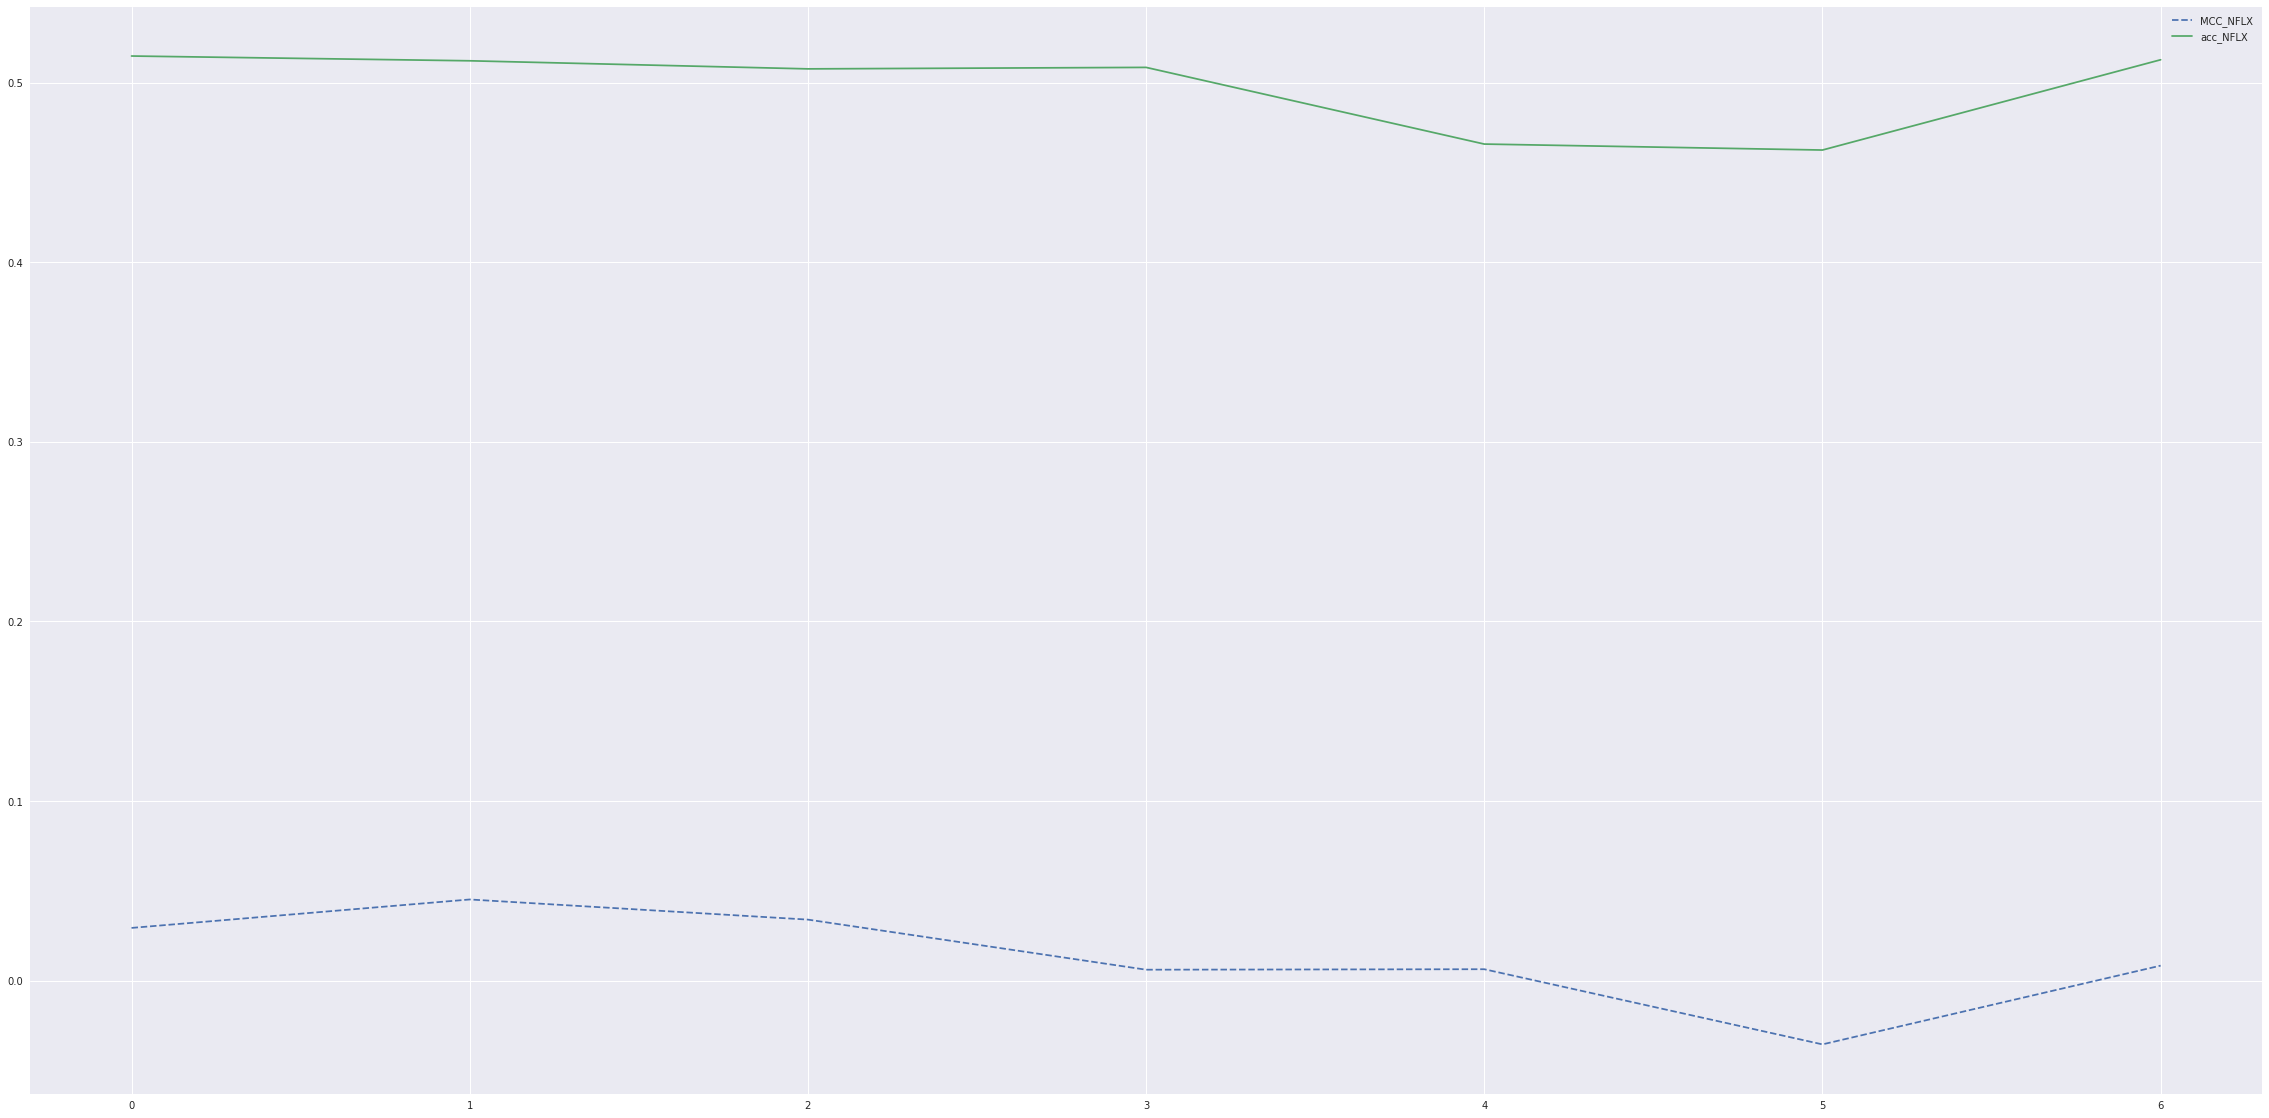

In [3]:
plt.figure(figsize=(40,20))

    
accs = list()
MCCs = list()
for TREND_WINDOW in TREND_WINDOWs:
    print(' TREND_WINDOW ', end='')

    #CONSTRUCT LABELS
    x_tv = []
    x_test = []
    y_tv = []
    y_test =  []
    for ticker in tickers:
        print(' '+ticker+' ', end='')
        news =  pd.read_csv(newsPath+ticker+'.csv')
        price =  pd.read_csv(pricePath+ticker+'.csv')
        price = price.rename(index=str, columns={"date": "DATE"})
        news = news.rename(index=str, columns={"initTime": "DATE"})
        news['DATE'] = [datetime.strptime(row, '%Y-%m-%d %H:%M:%S') for row in news['DATE']]
        # This datased is already GMT+0
        price['DATE'] = [datetime.strptime(row, '%Y-%m-%d %H:%M:%S') for row in price['DATE']]
        #ALLIGNMENT
        initDate = datetime(2017,5,22,14,0,0)
        finalDate = datetime(2018,6,20,19,0,0)
        price.drop(price[price.DATE > finalDate].index, inplace=True)
        price.drop(price[price.DATE < initDate].index, inplace=True)
        price = price.reset_index(drop=True)
        news.drop(news[news.DATE > finalDate].index, inplace=True)
        news.drop(news[news.DATE < initDate].index, inplace=True)
        news = news.reset_index(drop=True)

        #Controllo allignment
        for data in news['DATE']:
            if data not in price['DATE'].tolist():
                print(data)
        assert len(price) == len(news)

        # FEATURES EXTRACTION
        sentiment = news.drop(['Unnamed: 0', 'DATE'], axis=1)
        X = pd.concat([sentiment, sentiment.rolling(5).mean()],axis=1)
        X = pd.concat([X, sentiment.rolling(10).mean()],axis=1)
        X = pd.concat([X, sentiment.rolling(15).mean()],axis=1)
        X = pd.concat([X, sentiment.rolling(20).mean()],axis=1)
        X = np.asarray(X[20:]) #Rimuovo i primi per togliere i NaN
        price = price[20:]
        price = price.reset_index(drop=True)
        
        up = 0
        down = 0
        x = list()
        y = list()
        for i in range(0,len(price)-TREND_WINDOW):
            s=np.sign(price.iloc[i+TREND_WINDOW]['close']-price.iloc[i]['close'])
            if(s==-1):
                y.append(0)
                down +=1
            else:
                y.append(1)
                up +=1
            x.append(X[i])
        nt = math.floor(len(x)*trainPerc)
        x_tv += x[:nt]
        x_test += x[nt:]
        y_tv += y[:nt]
        y_test += y[nt:]
        
        
    #NORMALIZING
    min_max_scaler = preprocessing.MinMaxScaler()
    nt = len(x_tv)
    DS = x_tv+x_test
    DS = np.asarray(DS, dtype=float)
    DS = np.asarray(min_max_scaler.fit_transform(DS))
    x_tv += DS[:nt]
    x_test += DS[nt:]
    assert len(x_tv) == len(y_tv)
    
    x_tv = np.asarray(x_tv)
    y_tv = np.asarray(y_tv)
    x_test = np.asarray(x_test)
    y_test = np.asarray(y_test)
    
    print(x_tv.shape)
    print(y_tv.shape)
    print(x_test.shape)
    print(y_test.shape)
    print((sum(y_test)+sum(y_tv))/(len(y_test)+len(y_tv)))
    print(-(sum(y_test-1)+sum(y_tv-1))/(len(y_test)+len(y_tv)))

    

    cSpace = np.logspace(-4,4,10)
    gSpace = np.logspace(-4,4,10)
    #MODEL SELECTION: CV
    best_c = 0
    best_g = 0
    best_acc = 0
    for c in range(0,10):
        for g in range(0,10):
            cvacclist = list()
            print('.', end='')
            trainpoint=math.floor(len(x_tv)*0.50)
            dimval=math.floor((len(x_tv)-trainpoint)*0.25)
            endval=trainpoint+dimval
            for i in range(0,4):
                x_train = x_tv[0:trainpoint]
                y_train = y_tv[0:trainpoint]
                x_val = x_tv[trainpoint:endval]
                y_val = y_tv[trainpoint:endval]
                trainpoint = trainpoint+dimval
                endval = endval+dimval
                rbf_svm = svm.SVC(kernel='rbf',C=cSpace[c], gamma=gSpace[g])
                x_train,y_train = smote(x_train,y_train)
                x_val,y_val = smote(x_val,y_val)
                rbf_svm.fit(x_train,y_train)
                acc = rbf_svm.score(x_val,y_val)
                cvacclist.append(acc)

            cvacc=sum(cvacclist)/len(cvacclist)
            if(cvacc > best_acc):
                best_acc=cvacc
                best_c = cSpace[c]
                best_g = gSpace[g]


    rbf_svm = svm.SVC(kernel='rbf',C=best_c, gamma=best_g)
    x_tv,y_tv = smote(x_tv,y_tv)
    rbf_svm.fit(x_tv,y_tv)
    y_pred = rbf_svm.predict(x_test)
    acc = rbf_svm.score(x_test,y_test)
    confmatrix = confusion_matrix(y_test, y_pred)
    tn, fp, fn, tp = confmatrix.ravel()
    denom = (tp+fp)*(tp+fn)*(tn+fp)*(tn+fn)
    accs.append(acc)
    MCCs.append(0 if denom== 0 else (tp*tn -fp*fn)/sqrt(denom) )

plt.plot(range(len(MCCs)), MCCs, label='MCC_'+ticker, linestyle='dashed')
plt.plot(range(len(accs)), accs, label='acc_'+ticker)
print('MCCs: ', MCCs)
print('Accs: ',accs)

plt.legend()
plt.show()

Time To Market: 0
 AAPL  AMZN  GOOGL  MSFT  FB  INTC  CSCO  CMCSA  NVDA  NFLX (14820, 40)
(14820,)
(3710, 40)
(3710,)
0.5967620075553157
0.4032379924446843
....................................................................................................TTM:  0  acc:  0.5590296495956874  mcc:  0.11424203697818344
[[ 717  555]
 [1081 1357]]
Time To Market: 7
 AAPL  AMZN  GOOGL  MSFT  FB  INTC  CSCO  CMCSA  NVDA  NFLX (14820, 40)
(14820,)
(3710, 40)
(3710,)
0.5967620075553157
0.4032379924446843
....................................................................................................TTM:  7  acc:  0.49946091644204854  mcc:  0.05794723982132987
[[ 798  474]
 [1383 1055]]
Time To Market: 14
 AAPL  AMZN  GOOGL  MSFT  FB  INTC  CSCO  CMCSA  NVDA  NFLX (14820, 40)
(14820,)
(3710, 40)
(3710,)
0.5967620075553157
0.4032379924446843
....................................................................................................TTM:  14  acc:  0.48194070080862533  mcc:  0.026525600

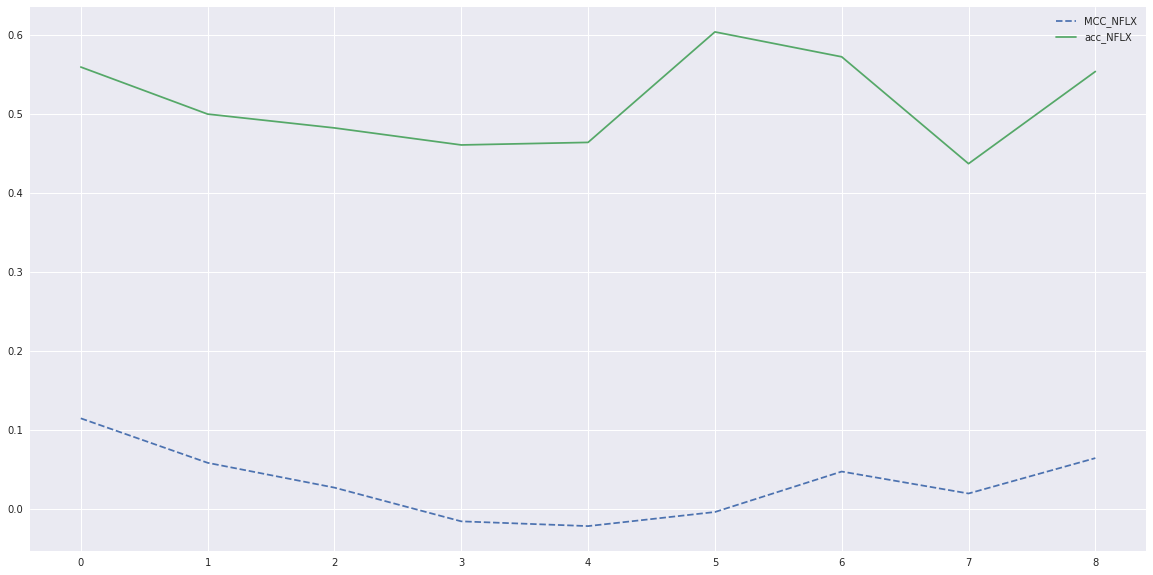

In [5]:
Ttm_range = [0, 7, 14, 21, 28, 35, 70, 105, 210]
TREND_WINDOW = 28
    
accs = list()
MCCs = list()
for ttm in Ttm_range:
    print('Time To Market: '+str(ttm))
    #CONSTRUCT LABELS
    x_tv = []
    x_test = []
    y_tv = []
    y_test =  []
    for ticker in tickers:
        print(' '+ticker+' ', end='')
        news =  pd.read_csv(newsPath+ticker+'.csv')
        price =  pd.read_csv(pricePath+ticker+'.csv')
        price = price.rename(index=str, columns={"date": "DATE"})
        news = news.rename(index=str, columns={"initTime": "DATE"})
        news['DATE'] = [datetime.strptime(row, '%Y-%m-%d %H:%M:%S') for row in news['DATE']]
        # This datased is already GMT+0
        price['DATE'] = [datetime.strptime(row, '%Y-%m-%d %H:%M:%S') for row in price['DATE']]
        #ALLIGNMENT
        initDate = datetime(2017,5,22,14,0,0)
        finalDate = datetime(2018,6,20,19,0,0)
        price.drop(price[price.DATE > finalDate].index, inplace=True)
        price.drop(price[price.DATE < initDate].index, inplace=True)
        price = price.reset_index(drop=True)
        news.drop(news[news.DATE > finalDate].index, inplace=True)
        news.drop(news[news.DATE < initDate].index, inplace=True)
        news = news.reset_index(drop=True)

        #Controllo allignment
        for data in news['DATE']:
            if data not in price['DATE'].tolist():
                print(data)
        assert len(price) == len(news)

        # FEATURES EXTRACTION
        sentiment = news.drop(['Unnamed: 0', 'DATE'], axis=1)
        X = pd.concat([sentiment, sentiment.rolling(5).mean()],axis=1)
        X = pd.concat([X, sentiment.rolling(10).mean()],axis=1)
        X = pd.concat([X, sentiment.rolling(15).mean()],axis=1)
        X = pd.concat([X, sentiment.rolling(20).mean()],axis=1)
        X = np.asarray(X[20:]) #Rimuovo i primi per togliere i NaN
        price = price[20:]
        price = price.reset_index(drop=True)
        
        up = 0
        down = 0
        x = list()
        y = list()
        for i in range(TREND_WINDOW-ttm,len(price)-ttm):
            s=np.sign(price.iloc[i+ttm]['close']-price.iloc[i+ttm-TREND_WINDOW]['close'])
            if(s==-1):
                y.append(0)
                down +=1
            else:
                y.append(1)
                up +=1
            x.append(X[i])
        nt = math.floor(len(x)*trainPerc)
        x_tv += x[:nt]
        x_test += x[nt:]
        y_tv += y[:nt]
        y_test += y[nt:]
        
        
    #NORMALIZING
    min_max_scaler = preprocessing.MinMaxScaler()
    nt = len(x_tv)
    DS = x_tv+x_test
    DS = np.asarray(DS, dtype=float)
    DS = np.asarray(min_max_scaler.fit_transform(DS))
    x_tv += DS[:nt]
    x_test += DS[nt:]
    assert len(x_tv) == len(y_tv)
    
    x_tv = np.asarray(x_tv)
    y_tv = np.asarray(y_tv)
    x_test = np.asarray(x_test)
    y_test = np.asarray(y_test)
    
    print((sum(y_test)+sum(y_tv))/(len(y_test)+len(y_tv)))
    print(-(sum(y_test-1)+sum(y_tv-1))/(len(y_test)+len(y_tv)))

    

    cSpace = np.logspace(-4,4,10)
    gSpace = np.logspace(-4,4,10)
    #MODEL SELECTION: CV
    best_c = 0
    best_g = 0
    best_acc = 0
    for c in range(0,10):
        for g in range(0,10):
            cvacclist = list()
            print('.', end='')
            trainpoint=math.floor(len(x_tv)*0.50)
            dimval=math.floor((len(x_tv)-trainpoint)*0.25)
            endval=trainpoint+dimval
            for i in range(0,4):
                x_train = x_tv[0:trainpoint]
                y_train = y_tv[0:trainpoint]
                x_val = x_tv[trainpoint:endval]
                y_val = y_tv[trainpoint:endval]
                trainpoint = trainpoint+dimval
                endval = endval+dimval
                rbf_svm = svm.SVC(kernel='rbf',C=cSpace[c], gamma=gSpace[g])
                x_train,y_train = smote(x_train,y_train)
                x_val,y_val = smote(x_val,y_val)
                rbf_svm.fit(x_train,y_train)
                acc = rbf_svm.score(x_val,y_val)
                cvacclist.append(acc)

            cvacc=sum(cvacclist)/len(cvacclist)
            if(cvacc > best_acc):
                best_acc=cvacc
                best_c = cSpace[c]
                best_g = gSpace[g]


    rbf_svm = svm.SVC(kernel='rbf',C=best_c, gamma=best_g)
    x_tv,y_tv = smote(x_tv,y_tv)
    rbf_svm.fit(x_tv,y_tv)
    y_pred = rbf_svm.predict(x_test)
    acc = rbf_svm.score(x_test,y_test)
    confmatrix = confusion_matrix(y_test, y_pred)
    tn, fp, fn, tp = confmatrix.ravel()
    denom = (tp+fp)*(tp+fn)*(tn+fp)*(tn+fn)
    mcc = 0 if denom== 0 else (tp*tn -fp*fn)/sqrt(denom) 
    accs.append(acc)
    MCCs.append(mcc)
    print('TTM: ',ttm,' acc: ',acc,' mcc: ',mcc)
    print(confmatrix)
    
    
plt.figure(figsize=(20,10))
plt.plot(range(len(MCCs)), MCCs, label='MCC_'+ticker, linestyle='dashed')
plt.plot(range(len(accs)), accs, label='acc_'+ticker)
print('MCCs: ', MCCs)
print('Accs: ',accs)

plt.legend()
plt.show()

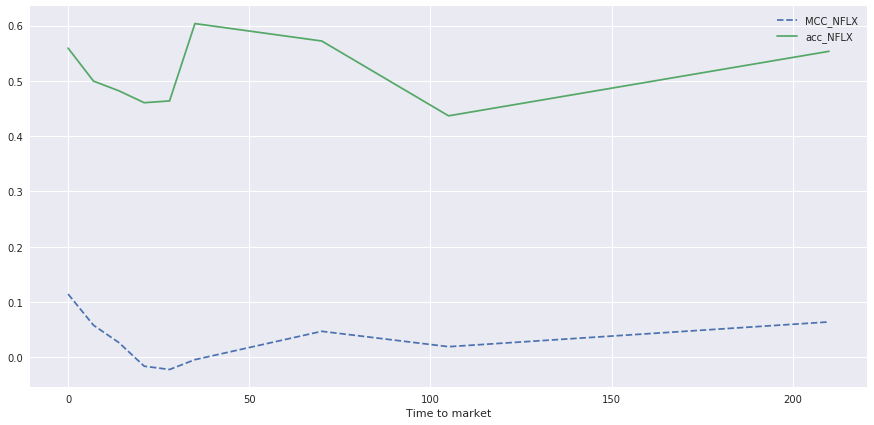

In [7]:

plt.figure(figsize=(15,7))
plt.plot([0, 7, 14, 21, 28, 35, 70, 105, 210], MCCs, label='MCC_'+ticker, linestyle='dashed')
plt.plot([0, 7, 14, 21, 28, 35, 70, 105, 210], accs, label='acc_'+ticker)
plt.xlabel('Time to market')

plt.legend()
plt.show()
    
    